In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [2]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [6]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [7]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_11 = df.iloc[:,9]
serie_11.head()

,#10
0,0.044965
1,0.044284
2,0.088023
3,0.001452
4,0.021937


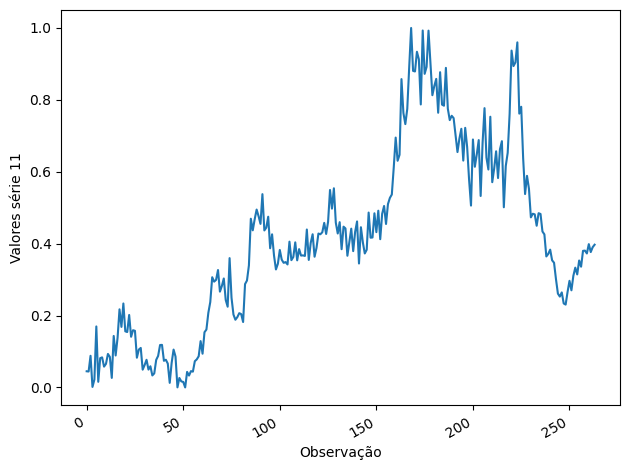

In [8]:
fig, ax = plt.subplots()

ax.plot(serie_11)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 11')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

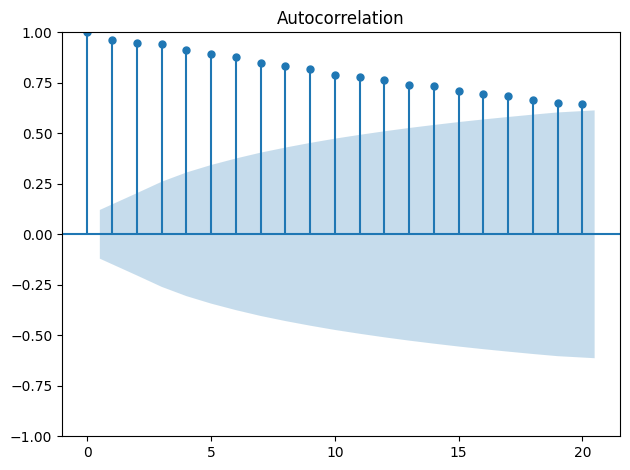

In [9]:
plot_acf(serie_11, lags=20);
plt.tight_layout()

In [10]:
advanced_decomposition = STL(serie_11,period=12).fit()

## Conjunto de treino

In [11]:
test = pd.DataFrame()
test["Values"] = serie_11.iloc[-12:]
test['naive_seasonal'] = serie_11.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_11.iloc[-24:-12].mean()

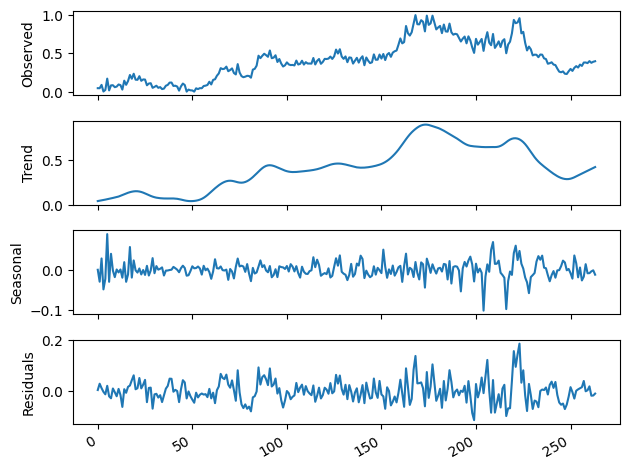

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [13]:
check_stationarity(serie_11,seasonal_period=12)

{'adf_stat': np.float64(-3.147990904973733),
 'p_value': np.float64(0.0231995455416266),
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 1}

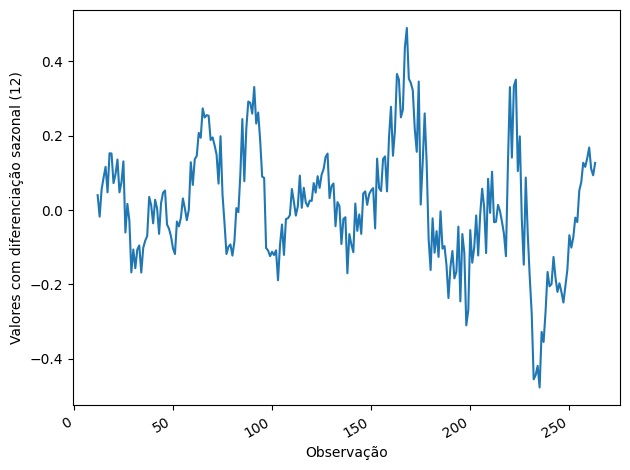

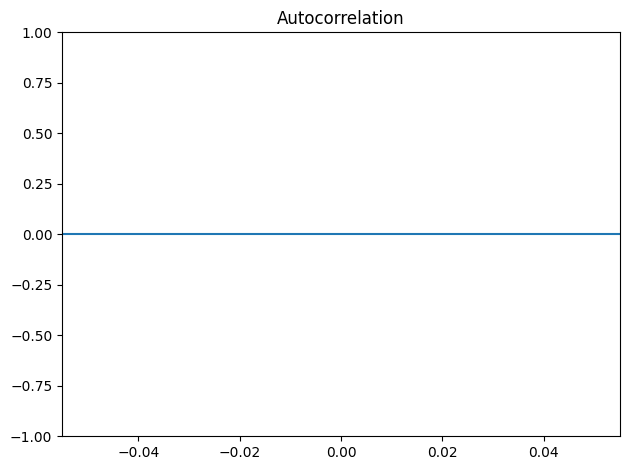

In [14]:
seasonal_diff = serie_11.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [15]:
train = serie_11[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(4,1,15) | AIC = -982.767617 \\
* SARIMA(1,0,1)(5,1,1,12) | AIC = -694.004658


In [16]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(4,1,15), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(4,0,3), seasonal_order=(3,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [17]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [18]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.310601,0.383300,0.288309,0.292014,0.296446
253,0.333247,0.353654,0.288309,0.295955,0.309324
254,0.314364,0.346898,0.288309,0.306194,0.337707
255,0.353173,0.301097,0.288309,0.317223,0.293567
256,0.335864,0.260986,0.288309,0.296817,0.280793
257,0.380008,0.252757,0.288309,0.313727,0.304745
258,0.380612,0.264373,0.288309,0.314002,0.285740
259,0.372696,0.233635,0.288309,0.304656,0.279854
260,0.398696,0.230483,0.288309,0.320418,0.326836
261,0.376591,0.265664,0.288309,0.315081,0.310930


### Análise de resíduos

In [19]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.940874
  2     0.987807
  3     0.987316
  4     0.994412
  5     0.998563
  6     0.999638
  7     0.999931
  8     0.999970
  9     0.999964
  10    0.999991
  11    0.999998
  12    0.999993
  13    0.999993
  14    0.999998
  15    0.999999
  16    1.000000
  17    1.000000
  18    1.000000
  19    0.999995
  20    0.999998
  21    0.999998
  22    0.999999
  23    0.999998
  24    0.998780
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1     0.433054
  2     0.494468
  3     0.491196
  4     0.657086
  5     0.653497
  6     0.739785
  7     0.590984
  8     0.652012
  9     0.735049
  10    0.784458
  11    0.805736
  12    0.861390
  13    0.878008
  14    0.913128
  15    0.911193
  16    0.937964
  17    0.944548
  18    0.955274
  19    0.965380
  20    0.965169
  21    0.961823
  22    0.967334
  23    0.965196
  24    0.973918
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64

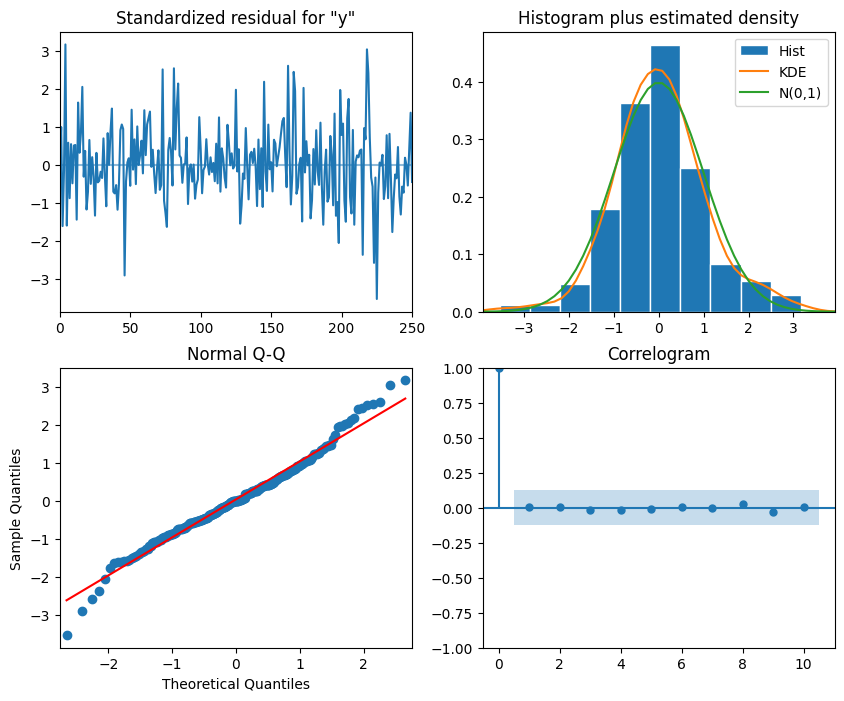

In [20]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [21]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.403195
  2     0.642018
  3     0.033513
  4     0.068147
  5     0.043174
  6     0.004910
  7     0.008103
  8     0.011415
  9     0.007929
  10    0.010071
  11    0.016348
  12    0.023406
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(9)},
 'squared_residuals': {'p_values': 1     0.689743
  2     0.919701
  3     0.000615
  4     0.000233
  5     0.000573
  6     0.000677
  7     0.001458
  8     0.001545
  9     0.002955
  10    0.005297
  11    0.004672
  12    0.007846
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(10)}}

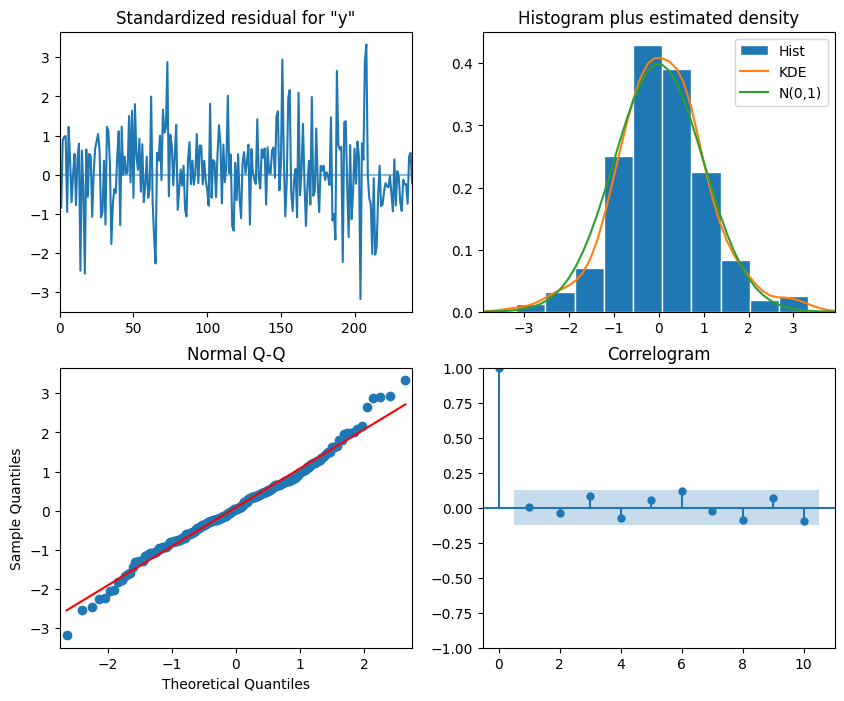

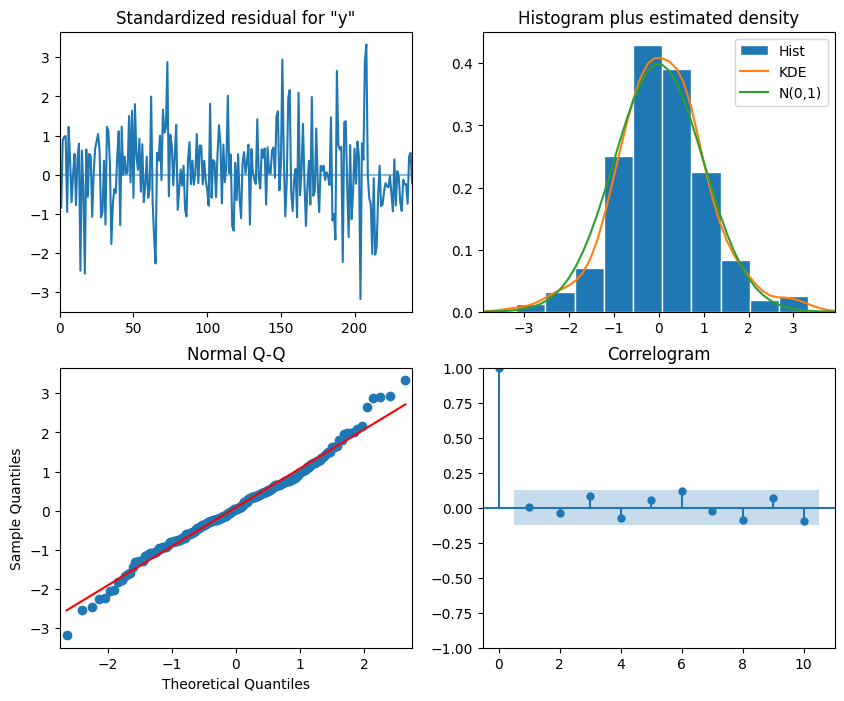

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_11[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add')
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train,trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.310601,0.383300,0.288309,0.292014,0.296446,0.275720,0.275655
253,0.333247,0.353654,0.288309,0.295955,0.309324,0.276735,0.276554
254,0.314364,0.346898,0.288309,0.306194,0.337707,0.277751,0.277452
255,0.353173,0.301097,0.288309,0.317223,0.293567,0.278768,0.278350
256,0.335864,0.260986,0.288309,0.296817,0.280793,0.279785,0.279249
257,0.380008,0.252757,0.288309,0.313727,0.304745,0.280803,0.280147
258,0.380612,0.264373,0.288309,0.314002,0.285740,0.281822,0.281046
259,0.372696,0.233635,0.288309,0.304656,0.279854,0.282842,0.281944
260,0.398696,0.230483,0.288309,0.320418,0.326836,0.283863,0.282843
261,0.376591,0.265664,0.288309,0.315081,0.310930,0.284885,0.283741


In [24]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     4.859168e-01
2     7.709753e-01
3     1.025021e-07
4     1.154833e-07
5     3.677550e-07
6     5.007723e-08
7     2.354763e-08
8     3.837049e-08
9     6.555277e-09
10    1.061453e-10
11    2.794375e-10
12    6.941861e-10
13    1.303101e-10
14    1.262346e-11
15    1.927344e-11
16    4.510432e-12
17    7.988669e-14
18    1.331451e-13
19    2.763579e-13
20    4.650394e-15
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(18)}, 'squared_residuals': {'p_values': 1     0.085261
2     0.200005
3     0.101742
4     0.048296
5     0.076054
6     0.056673
7     0.078550
8     0.101784
9     0.109689
10    0.025717
11    0.002551
12    0.003987
13    0.004675
14    0.004913
15    0.005724
16    0.008769
17    0.012255
18    0.018039
19    0.017278
20    0.015736
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(12)}}


In [25]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.424
Optimized:,True,AIC,-1601.720
Trend:,Additive,BIC,-1587.603
Seasonal:,None,AICC,-1601.378
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,18:01:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6201518,alpha,True
smoothing_trend,1.9522e-15,beta,True


## Theta

In [26]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        18:01:50   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0019124579827803413
alpha    0.6196979040810048
---------------------------
Forecast: 252    0.236363
253    0.244098
254    0.255092
255    0.249843
256    0.258767
257    0.259372
258    0.259465
259    0.265867
260    0.261891
261    0.255959
262    0.257627
263    0.250429
Name: forecast, dtype: float64


## Visualização das predições


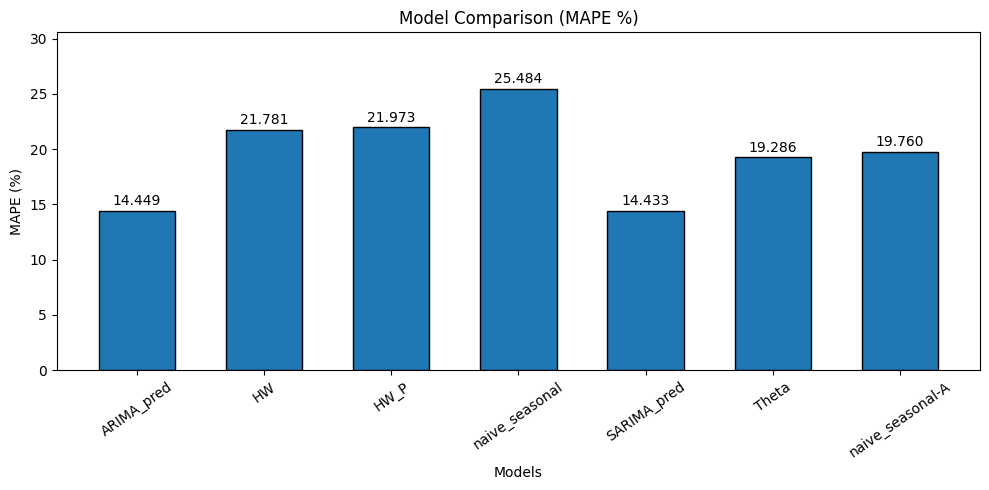

{'ARIMA_pred': np.float64(14.449119342502511),
 'HW': np.float64(21.781095806868088),
 'HW_P': np.float64(21.972865254360855),
 'naive_seasonal': np.float64(25.48400070852706),
 'SARIMA_pred': np.float64(14.432830892420842),
 'Theta': np.float64(19.286347533439827),
 'naive_seasonal-A': np.float64(19.7595182415043)}

In [27]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [28]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.310601,0.383300,0.288309,0.292014,0.296446,0.275720,0.275655,0.267144
253,0.333247,0.353654,0.288309,0.295955,0.309324,0.276735,0.276554,0.277018
254,0.314364,0.346898,0.288309,0.306194,0.337707,0.277751,0.277452,0.291185
255,0.353173,0.301097,0.288309,0.317223,0.293567,0.278768,0.278350,0.284402
256,0.335864,0.260986,0.288309,0.296817,0.280793,0.279785,0.279249,0.295958
257,0.380008,0.252757,0.288309,0.313727,0.304745,0.280803,0.280147,0.296744
258,0.380612,0.264373,0.288309,0.314002,0.285740,0.281822,0.281046,0.296866
259,0.372696,0.233635,0.288309,0.304656,0.279854,0.282842,0.281944,0.305227
260,0.398696,0.230483,0.288309,0.320418,0.326836,0.283863,0.282843,0.300028
261,0.376591,0.265664,0.288309,0.315081,0.310930,0.284885,0.283741,0.292310


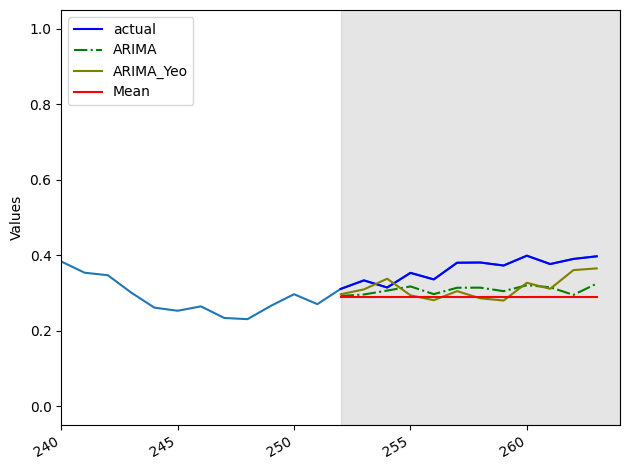

In [29]:
fig, ax = plt.subplots()

ax.plot(serie_11)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA')
#ax.plot(test['HW'], 'cyan', label='ES')
#ax.plot(test['Theta'], 'black', label='Theta')
#ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
#ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'red', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

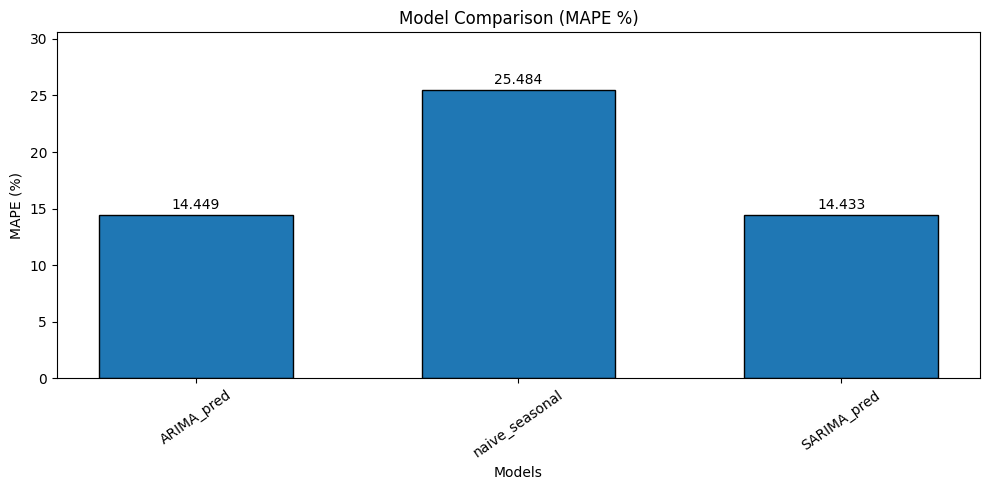

{'ARIMA_pred': np.float64(14.449119342502511),
 'naive_seasonal': np.float64(25.48400070852706),
 'SARIMA_pred': np.float64(14.432830892420842)}

In [30]:
columns = ['ARIMA_pred','naive_seasonal','SARIMA_pred']
plot_model_mape(test,'Values',columns)

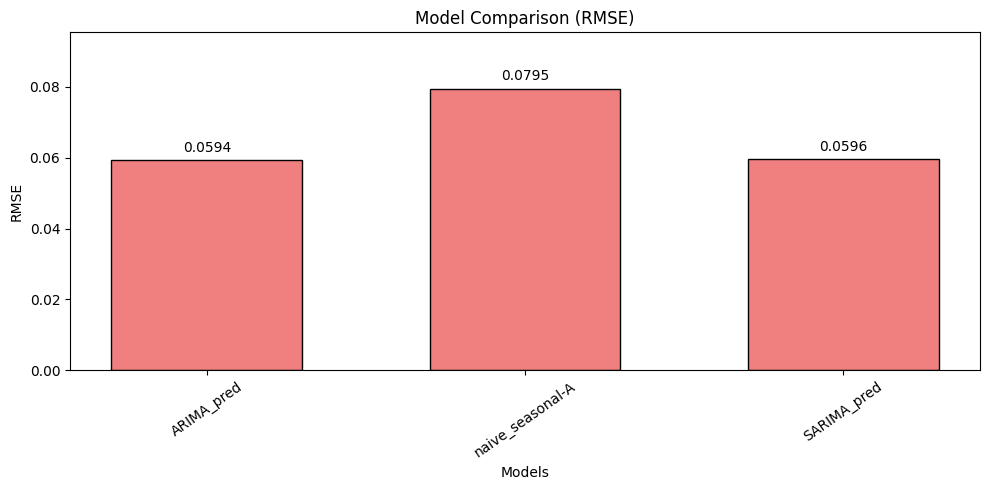

In [31]:
columns_to_plot = ['ARIMA_pred','naive_seasonal-A','SARIMA_pred']
rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [32]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_11.values.reshape(-1, 1)).flatten(), index=serie_11.index)


SARIMA_model = SARIMAX(train_transformed, order=(4,0,3), seasonal_order=(3,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

forecast_steps = 12
forecast_SARIMA = SARIMA_model_fit.forecast(steps=forecast_steps)

forecast_original_scale = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()

forecast_original_scale


array([0.35967902, 0.39418756, 0.42975063, 0.4325418 , 0.46701436,
       0.48055527, 0.46354986, 0.47804079, 0.47983455, 0.45750423,
       0.45855815, 0.44613439])

In [33]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast_original_scale)
with open("11.csv", "w") as f:
    for i, value in enumerate(forecast_original_scale, 1):
        f.write(f"{value:}\n")